# Example converting IDL code to Python using ChatGPT

_Author: Rebekah Esmaili, Science and Technology Corp (STC)_

This example contains functions used in a program searches a VIIRS DNB image find the closest point to a given latituide-longitude coordinate. We will explore two simpler functions, one that calculates the distance between two points (```realdistance```) and one that calculates the closest point when given an array of data (```areasearch```).

Below is an image of our example data. The two boxes are the Daynight Band (DNB) granule (in color) and the search point (in red). We want to find the closet pair of points.

![](test_data.png)

We will only need a few simple packages to run this example:

In [179]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
import h5py
import numpy as np
import time


## Exercise 1: Calculate the Distance Between Points

Before we convert any code, we need a sample case to compare before/after. Below is some sample text data that I wrote to use to test our function (this was generated using ```test_data.py```). 

In IDL, this code would look something like this:
```IDL
geofile = 'data/GDNBO_j01_d20230825_t0700543_e0702188_b29878_c20230825074232550000_oebc_ops.h5'
radfile = 'data/SVDNB_j01_d20230825_t0700543_e0702188_b29878_c20230825074447069000_oebc_ops.h5'

fid=h5f_open(geofile);
lonid=h5d_open(fid,'/All_Data/VIIRS-DNB-GEO_All/Longitude_TC');
lon=h5d_read(lonid) &  h5d_close,lonid
latid=h5d_open(fid,'/All_Data/VIIRS-DNB-GEO_All/Latitude_TC'); 
lat=h5d_read(latid) &  h5d_close,latid;
h5f_close,fid

fid=h5f_open(radfile);
radid=h5d_open(fid,'/All_Data/VIIRS-DNB-SDR_All/Radiance');
rad=h5d_read(radid) &  h5d_close,radid;
h5f_close,fid

```

Run the code block below to import the data in using Python libraries. We will use it to test our functions.

In [151]:
# Sample file path/names:
geofile = 'data/GDNBO_j01_d20230825_t0700543_e0702188_b29878_c20230825074232550000_oebc_ops.h5'
radfile = 'data/SVDNB_j01_d20230825_t0700543_e0702188_b29878_c20230825074447069000_oebc_ops.h5'

# Open the sample geo file, extract the lat, lon coordinates
# Note: Scaling the grid by 100 to save processing time, for demo purposes only
fid = h5py.File(geofile, 'r')
lon_viirs = fid['/All_Data/VIIRS-DNB-GEO_All/Longitude_TC'][:,:]
lat_viirs = fid['/All_Data/VIIRS-DNB-GEO_All/Latitude_TC'][:,:]

# Open the sample radiance file, extract the lat, lon coordinates
fid_rad = h5py.File(radfile, 'r')
rad_viirs = fid_rad['/All_Data/VIIRS-DNB-SDR_All/Radiance'][:,:]

The point that we'll search for is:

In [168]:
# (lat, lon)
targetlat = 53.0
targetlon = -78.0

As you can see, the dimensions are the same size in the test data. Now, lets use this data to calculate the distance between a two pairs of latitude-longitude coordinates. The function can handle both floats and arrays of floats.

In the code block below, rewrite the following IDL function using [ChatGPT](https://chat.openai.com/):

```IDL
FUNCTION realdistance,lat1,lon1,lat2,lon2
;return real earth distance in km
	PI=3.14159d
	temp=0.0d
	earth_radius=6378.0d ; //km
		;convert all to radians:
		tmplat1=double(lat1*PI/180.0);
		tmplon1=double(lon1*PI/180.0);
		tmplat2=double(lat2*PI/180.0);
		tmplon2=double(lon2*PI/180.0);

		temp=sin(tmplat1)*sin(tmplat2) + cos(tmplat1)*cos(tmplat2)*cos(tmplon2-tmplon1);
		temp=acos(temp);
		temp=temp*earth_radius;
return, temp;
END
```

***Solution:***


In [114]:
def realdistance(lat1, lon1, lat2, lon2):
    PI = np.pi
    earth_radius = 6378.0  # km
    tmplat1 = np.radians(lat1)
    tmplon1 = np.radians(lon1)
    tmplat2 = np.radians(lat2)
    tmplon2 = np.radians(lon2)
    temp = np.sin(tmplat1) * np.sin(tmplat2) + np.cos(tmplat1) * np.cos(tmplat2) * np.cos(tmplon2 - tmplon1)
    temp = np.arccos(temp)
    temp = temp * earth_radius
    return temp

Now, let's test our function using our example data we imported earlier data (```lat1```, ```lon1```, ```lon1```, ```lon2```). 

Part of testing larger scripts is breaking them down into smaller bite sized peices and test/validate. Run the code block below to see if the function works correctly using the lat/lon arrays with three different values.

In [152]:
distances = realdistance(lat[0,0], lon[0,0], pt[0], pt[1])

print("Coordiantes:", lat[0,0], lon[0,0], pt[0], pt[1])
print("Distances:", distances, "km")

Coordiantes: 56.144375 -95.91549 56.97664 -78.2857
Distances: 1082.3663195163854 km


It's also a good idea to time your functions when converting from IDL to python. We can use the time function in the time library to determine the start/end processing time in seconds:

In [184]:
start_time = time.time()
d = realdistance(lat_viirs, lon_viirs, targetlat, targetlon)
end_time = time.time()
print("Computing time:", end_time - start_time, "seconds")

Computing time: 0.222883939743042 seconds


## Example 2: Calculate the Orbital intersection where two gridpoints overlap 

Now that we have tested the distance function, let's convert an IDL function that uses ```realdistance```. The function below calculates the radiance at the point closest to the provided one. It's longer than the last one, so we'll break it down into part 1 and part 2.

```IDL
PRO areasearch, lat, lon, rad, targetlat, targetlon

    ; ============== Part 1 ==============

    ; to reduce looping, see if the granule even contains the point,
    ; if not, continue to next file
    ; Searching in quarter degree
    x=where(abs(lat-targetlat) LE 0.125)
    if x(0) eq -1 then begin
            print, 'Not found.'
            continue 
    endif

    ; calculate the distance between the remaining points
    d=realdistance(lat(x),lon(x),targetlat,targetlon);

    ; check if any of the remaining points are within 1km of the 
    ; given point
    xind=where(d LE 1.0); 
    if (xind(0) eq -1) then begin
        print, 'Not found'
        continue 
    endif

    ; ============== Part 2 ==============

    ; The indices of all matches
    x1=x(xind);

    ; Find the max radiance value within the closest points
    mx=max(rad(x1),location); 
    ind= ARRAY_INDICES(rad, x1(location))

    I0=ind(0);
    J0=ind(1);
    rad0=mx;
    offset=1
    i1=I0-offset
    i2=I0+offset
    j1=j0-offset
    j2=j0+offset
    low=0	   
    high=768
    width=4064

	;make sure it is not on the edge:
	if ((i1 ge low) and (i1 lt width) and (i2 ge low) and (i2 lt width)$
             and (j1 ge low) and (j1 lt high) and (j2 ge low) and (j2 lt high)) then begin

        ;compute the total radiance within a rectangle around the brightest pixel
        radarea=total(rad(i1:i2,j1:j2))

        ;compute the min radiance within a rectangle around the brightest pixel
        minrad=Min(rad(i1:i2,j1:j2)) 
        
        ;compute the min radiance within a rectangle around the brightest pixel
        targetDist=realdistance(lat(I0,J0),lon(I0,J0),targetlat,targetlon);

		print,"Found."
		print, minrad, radarea, targetDist;

    endif
END


```

Copy/paste the code in Part 1 into ChatGPT. Enter the results below.

In [312]:
# start_time = time.time()

# Searching in one-degree range
x = np.where(np.abs(lat_viirs - targetlat) <= 1.0)

# Calculate the distance between the points within one degree
d = realdistance(lat_viirs[x], lon_viirs[x], targetlat, targetlon)

# Check if any of the remaining points are within 1km of the 
# target point
xind = np.where(d <= 1.0)

# end_time = time.time()
# print("Computing time:", end_time - start_time, "seconds")

Next, let's tackle part 2. This part finds the total and minimum radiance around the given point. Try to run the code as-is... does it work?

In [317]:
# Find the max radiance value within the closest points
mx = np.max(rad_viirs[x1])
location = np.argmax(rad_viirs[x1])

# Use the location of the maximum pixel to find all neighboring points
ind = np.unravel_index(location, rad_viirs.shape)
I0 = ind[0]
J0 = ind[1]
offset = 1
i1 = I0 - offset
i2 = I0 + offset
j1 = J0 - offset
j2 = J0 + offset

# Make sure the points are within
low = 0	   
height = 768
width = 4064

# Make sure it is not on the edge
if (low <= i1 < height) and (low <= i2 < height) and (low <= j1 < width) and (low <= j2 < width):
    # Compute the total radiance within a rectangle around the brightest pixel
    radarea = np.sum(rad_viirs[i1:i2+1, j1:j2+1])

    # Compute the min radiance within a rectangle around the brightest pixel
    minrad = np.min(rad_viirs[i1:i2+1, j1:j2+1]) 

    # Compute the min radiance within a rectangle around the brightest pixel
    targetDist = realdistance(lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)

    print("Found.")
    print(minrad, radarea, targetDist, lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)


Found.
3.380527e-10 5.323567e-09 1857.460479965974 49.614746 -51.699883 53.0 -78.0


The code *techincally* works, but the distance is very far. So there was an index error.

The first error takes place in

```
# The indices of all matches
x1 = x[0][xind]

# Find the max radiance value within the closest points
mx = np.max(rad_viirs[x1])
location = np.argmax(rad_viirs[x1])
```

The above code fails at the ```mx = np.max(rad_viirs[x1])``` because x1 is a 1D index but rad_viirs is 2D.


Problem #1: ChatGPT incorrectly converted the IDL expression ```x1=x(xind);```. Here's a simple test. We want the index where the distance is the MIMIMUM value, right? We can check this. Let's print d[xind] and d[x1] and see if the distance is small. You'll see that xind correctly prints zeros (below zero km apart from the target point) whereas x1 is much further.

In [315]:
print("distances (km) with xind :", d[xind])
print("distances (km) with x1:", d[x1])

distances (km) with xind : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
distances (km) with x1: [1048.502  1048.502  1049.194  1049.194  1049.194  1049.8716 1049.8716
 1049.8716 1050.5558 1050.5558 1050.5558 1050.5558 1050.5558 1050.5558
 1051.2488 1051.2488 1051.9807]


In [277]:
# Get the max value of the radiance in the search box:
mx = np.max(rad_viirs[x][xind])
location = np.argmax(rad_viirs[x][xind])

Update your code below with the fix:

In [320]:
# Find the max radiance value within the closest points
mx = np.max(rad_viirs[x][xind])
location = np.argmax(rad_viirs[x][xind])
ind = np.unravel_index(location, rad_viirs.shape)

# Use the location of the maximum pixel to find all neighboring points
I0 = ind[0]
J0 = ind[1]
offset = 1
i1 = I0 - offset
i2 = I0 + offset
j1 = J0 - offset
j2 = J0 + offset

# Make sure the points are inside the swath
low = 0	   
height = 768
width = 4064

# Make sure it is not on the edge
if (low <= i1 < height) and (low <= i2 < height) and (low <= j1 < width) and (low <= j2 < width):
    # Compute the total radiance within a rectangle around the brightest pixel
    radarea = np.sum(rad_viirs[i1:i2+1, j1:j2+1])

    # Compute the min radiance within a rectangle around the brightest pixel
    minrad = np.min(rad_viirs[i1:i2+1, j1:j2+1]) 

    # Compute the min radiance within a rectangle around the brightest pixel
    targetDist = realdistance(lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)

    print("Found.")
    print(minrad, radarea, targetDist, lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)


There was no error, but there was also no output! The print statement is inside the if statement, so we need to see why it didn't trigger. Let's print the if statement:

In [321]:
(low <= i1 < height), (low <= i2 < height), (low <= j1 < width), (low <= j2 < width)

(False, True, True, True)

We see the first condition failed, let's print the values:

In [322]:
print(I0, J0)
print(i1, i2, j1, j2)

0 12
-1 1 11 13


From above, you'll see i1 is -1, which is not a permitted index in Python. The resulting indices are negative, and IDL has different index behavior than Python. "In IDL 8.0 however, a negative index is allowed, which will lead to the last element of the array being accessed, perhaps unintentionally, with no error thrown." In python, an error is thrown.

Problem #2: ChatGPT incorrectly converted the index from unravel_indices.

Similar to the previous problem, the returned indices are from the smaller, 1D array and not from the full-sized array.

* IDL's ```ARRAY_INDICES(Array, Index [, /DIMENSIONS] )``` function converts one-dimensional subscripts of an array into corresponding multi-dimensional subscripts.

* Python's ``np.unravel_index(indices, shape)`` function converts a flat index or array of flat indices into a tuple of coordinate arrays.

The fix is below, and it doesn't resemble the IDL code at all. We have to return to the purpose of the code: we want to find the index where the radiance is maximum within the closest points.

Below, we create a mask that has three conditions:
1. Determine index where radiance == maximum radiance
2. Determine index where latitude == latitude @ maximum radiance
3. Determine index where longitude == longitude @ maximum radiance

The resulting ```I0, J0``` are the corresponding indices in the original 2D array

In [324]:
# Fix the neighboring points
mask = (rad_viirs == rad_viirs[x][xind][location]) & (lon_viirs == lon_viirs[x][xind][location]) & (lat_viirs == lat_viirs[x][xind][location])
I0, J0 = np.where(mask)[0].item(), np.where(mask)[1].item()

Let's check the output:

In [325]:
i1=I0-offset
i2=I0+offset
j1=J0-offset
j2=J0+offset

print(i1, i2, j1, j2)

404 406 1408 1410


The rest of code works as expected. Let's put the pieces together:

In [302]:
# Find the max radiance value within the closest points
mx = np.max(rad_viirs[x][xind])
location = np.argmax(rad_viirs[x][xind])

# Fix the neighboring points
mask = (rad_viirs == rad_viirs[x][xind][location]) & (lon_viirs == lon_viirs[x][xind][location]) & (lat_viirs == lat_viirs[x][xind][location])
I0, J0 = np.where(mask)[0].item(), np.where(mask)[1].item()

offset = 1
#  IDL variables are not case sensitive, Python variables are!
i1 = I0 - offset
i2 = I0 + offset
j1 = J0 - offset
j2 = J0 + offset

low = 0
width = 4064
height = 768

# Make sure it is not on the edge:
if (low <= i1 < height) and (low <= i2 < height) and (low <= j1 < width) and (low <= j2 < width):

    # Compute the total radiance within a rectangle around the brightest pixel
    radarea = np.sum(rad_viirs[i1:i2+1, j1:j2+1])
    # Compute the min radiance within a rectangle around the brightest pixel
    minrad = np.min(rad_viirs[i1:i2+1, j1:j2+1])

    radarea = np.sum(rad_viirs[x][xind])
    # Compute the min radiance within a rectangle around the brightest pixel
    minrad = np.min(rad_viirs[x][xind])

    targetDist = realdistance(lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)
    print("Found.")

    print(minrad, radarea, targetDist, lat_viirs[I0, J0], lon_viirs[I0, J0], targetlat, targetlon)

Found.
3.171985e-11 2.942829e-09 1.0960519464499483 52.995228 -77.991 53.0 -78.0


Success! We calcualted the radiances at the closest point. The resulting VIIRS coordiantes (52.995228N, 77.991W) is within 1.09 km of the provided point.

## Best Practices

In conclusion, here are some recommendations and challenges illustrated by this example:

1. ChatGPT provides an excellent first guess of the code, but expect to refine the code.
2. Legacy code often requires some clean-up, build in time to remove usused code, unnecesary variables, etc.
3. Fast Python code avoids loops and uses optimized built-in functions, like those in NumPy.
4. Use test data to check if the output in Python matches in the output in IDL

In [8]:
def get_getlatlon(filename, spacing):
    grpname = 'All_Data/VIIRS-IMG-GEO_All/'

    fid = h5py.File(filename, "r")
    lat = fid[grpname+'Latitude'][::spacing, ::spacing]
    lon = fid[grpname+'Longitude'][::spacing, ::spacing]

    return lat, lon

In [9]:
filenames = ["GIMGO_j01_d20230815_t0152152_e0153398_b29733_c20230815022929302000_oeac_ops.h5", "GIMGO_j01_d20230815_t1440238_e1441484_b29740_c20230815150608044000_oeac_ops.h5"]
for i, filename in enumerate(filenames):
    lat1, lon1 = get_getlatlon(filename,100)
    oname = "viirs"+str(i)

    np.savetxt(f'{oname}_lat.tsv', lat1, delimiter='\t')
    np.savetxt(f'{oname}_lon.tsv', lon1, delimiter='\t')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [46]:
fig = plt.figure(figsize=[8,8])
ax = plt.axes(projection=ccrs.PlateCarree())

xx = lon.flatten()
yy = lat.flatten()

# VIIRS
xx = lon.flatten()
yy = lat.flatten()
zz = rad.flatten()
tmp_rad = ax.scatter(xx[::1000], yy[::1000], c=zz[::1000], transform=ccrs.PlateCarree(), s=0.5)
# plt.colorbar(tmp_rad)


# Search point
ax.scatter(-71.55289, 51.44279, color='red', label='Search Point', transform=ccrs.PlateCarree())

# Set map features
ax.set_extent([-100, 0, 40, 65], ccrs.PlateCarree())  # Adjust the extent for Canada

# ax.set_global()
ax.coastlines()
ax.gridlines()

# Add gridlines with lat/lon labels
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_aspect('equal', adjustable='datalim')
ax.legend()
plt.savefig('test_data.png')
plt.close()

In [ ]:
lat1

array([[27.007751, 26.965017, 26.922995, ..., 22.943195, 22.802568,
        22.645555],
       [26.669699, 26.627338, 26.585693, ..., 22.61647 , 22.475872,
        22.318962],
       [26.331934, 26.289944, 26.24867 , ..., 22.29025 , 22.149817,
        21.993084],
       ...,
       [22.744867, 22.697515, 22.651915, ..., 18.786716, 18.653826,
        18.505775],
       [22.407019, 22.36005 , 22.31483 , ..., 18.457897, 18.324957,
        18.176882],
       [22.069422, 22.022827, 21.977983, ..., 18.129663, 17.996769,
        17.848766]], dtype=float32)

In [96]:
targetlat = 51.464645
targetlon = -71.55955
lon_grid = lon[::10,::10]
lat_grid = lat[::10,::10]
rad_grid = rad[::10,::10]

# See if there's a close latitude
x = np.where(np.abs(lat_grid - targetlat) <= 1.0)
print(x[0].size)

if x[0].size == 0:

# See if there's a close latitude

d = realdistance(lat_grid, lon_grid, targetlat, targetlon)
xind = np.where(d <= 1.0)

print(xind[0].size)

x1 = x[0][xind]

x1_location = np.unravel_index(x1[0], rad.shape)
I0, J0 = x1_location
rad0 = rad[I0, J0]
offset = 1
i1, i2 = I0 - offset, I0 + offset
j1, j2 = J0 - offset, J0 + offset
low, high = 0, 768
width = 4064

if (low <= i1 < width) and (low <= i2 < width) and (low <= j1 < high) and (low <= j2 < high):
    radarea = np.sum(rad[i1:i2+1, j1:j2+1])
    minrad = np.min(rad[i1:i2+1, j1:j2+1])
    targetDist = realdistance(lat_grid[I0, J0], lon_grid[I0, J0], targetlat, targetlon)
    print(lat_grid[I0, J0], lon_grid[I0, J0], targetDist)

# areasearch(-78.2857, -56.97664, lon[::100,::100], lat_grid[::100,::100])



8922
1


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

d = realdistance(lat_grid, lon_grid, targetlat, targetlon)


In [170]:
d = realdistance(lat_viirs, lon_viirs, targetlat, targetlon)


C:\Users\rebekah\AppData\Local\Temp\ipykernel_36640\1060365138.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  tmp = plt.pcolormesh(lon_viirs[::10,::10], lat_viirs[::10,::10], d[::10,::10])


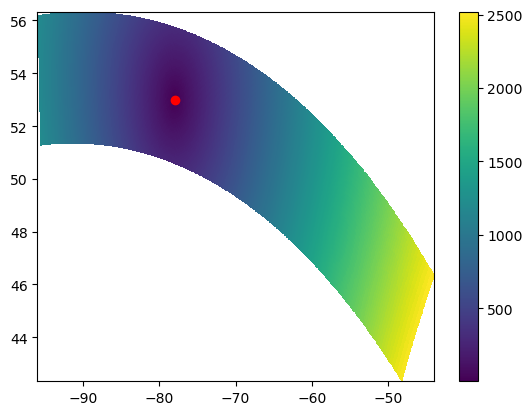

In [171]:
plt.figure()
tmp = plt.pcolormesh(lon_viirs[::10,::10], lat_viirs[::10,::10], d[::10,::10])
plt.scatter(targetlon, targetlat, c='red')
plt.colorbar(tmp)
plt.show()